In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE

In [2]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.chemutils import get_ecfp6, QEPPIScorer

In [15]:
sns.set_theme(style='ticks')

In [4]:
def read_molecules_zinc(filepath, K=3000):
    df = pd.read_csv(filepath).loc[:, ('smiles', 'ba_bcl2', 'ba_bclxl', 'ba_bclw')]
    
    idx = (df.loc[:,'ba_bcl2'] > 9.069) & (df.loc[:,'ba_bclxl'] > 8.283) & (df.loc[:,'ba_bclw'] > 6.999)
    df = df[idx].reset_index(drop=True)
    
    smiles = df.loc[:K,'smiles'].values.tolist()
    
    return smiles

In [5]:
smiles_zinc = read_molecules_zinc(os.path.join(os.pardir, 'data', 'zinc15', 'zinc15_train_full.csv'))

In [6]:
def read_molecules(input_dir, K=1000):
    smiles = set()
    
    for i in range(10):
        
        filepath = os.path.join(input_dir, f'smi_after.csv.{i}')
        df = pd.read_csv(filepath).loc[:, ('smiles', 'bcl2', 'bclxl', 'bclw')].drop_duplicates(ignore_index=True)
        
        idx = (df.loc[:,'bcl2'] > 9.069) & (df.loc[:,'bclxl'] > 8.283) & (df.loc[:,'bclw'] > 6.999)
        df = df[idx]
        
        for smi in df.loc[:,'smiles'].values:
            smiles.add(smi)
        
        if len(smiles) > K:
            break
            
    return list(smiles)[:K]

In [7]:
## generated by ReBADD-SE
smiles_rebadd = read_molecules(os.path.join('outputs_7_calculate_properties_generated', 'frag+reinforce+scst+offpolicy'))

## generated by ReBADD-SE
smiles_rationale = read_molecules(os.path.join('baseline', 'RationaleRL'))

## generated by ReBADD-SE
smiles_mars = read_molecules(os.path.join('baseline', 'MARS'))

In [8]:
calc_qeppi = QEPPIScorer()

In [9]:
def make_dataset(smiles, labels):
    
    fps = []
    ys = []
    qs = []
    
    for smi, y in tqdm(zip(smiles, labels)):
        try:
            fp = get_ecfp6(smi)
            fp = np.array([b for b in fp.ToBitString()], dtype=int)
            q = calc_qeppi(smi)
            
            fps.append(fp)
            ys.append(y)
            qs.append(q)            
        except:
            pass
        
    fps = np.array(fps, dtype=float)
    points = TSNE(random_state=2022).fit_transform(fps)
    
    return {'X':points, 'Y':ys, 'Q':qs, 'F':fps}

In [10]:
smi_navitoclax = 'CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(=O)(=O)C4=CC(=C(C=C4)NC(CCN5CCOCC5)CSC6=CC=CC=C6)S(=O)(=O)C(F)(F)F)C7=CC=C(C=C7)Cl)C'

dataset = make_dataset(
    smiles = smiles_rebadd + smiles_rationale + smiles_mars + smiles_zinc,
    labels = (['ReBADD-SE'] * len(smiles_rebadd))
             + (['RationaleRL'] * len(smiles_rationale))
             + (['MARS'] * len(smiles_mars))
             + (['ZINC15'] * len(smiles_zinc)),
)

2208it [00:02, 761.67it/s]


In [11]:
def make_scatterplot(dataset):

    fig, ax = plt.subplots(1,1,figsize=(5,5))

    ax.scatter(x=dataset['X'][~dataset['Y'],0], y=dataset['X'][~dataset['Y'],1], label='Generated')
    ax.scatter(x=dataset['X'][dataset['Y'],0], y=dataset['X'][dataset['Y'],1], label='Desired')
    
    ax.legend(loc='best')
    
    plt.show()

In [12]:
data = pd.DataFrame({
    'X1':dataset['X'][:,0],
    'X2':dataset['X'][:,1],
    'Z':dataset['Q'],
    'Y':dataset['Y'],
})

In [13]:
data

,X1,X2,Z,Y
0,30.897743,13.014380,0.285000,ReBADD-SE
1,14.180852,12.866172,0.424172,ReBADD-SE
2,39.584320,28.383492,0.106934,ReBADD-SE
3,57.123154,-18.492586,0.226311,ReBADD-SE
4,35.177967,8.741712,0.156800,ReBADD-SE
...,...,...,...,...
2203,-10.107100,-16.189442,0.847111,ZINC15
2204,-9.800925,-17.273304,0.619400,ZINC15
2205,-9.025282,-17.997505,0.906752,ZINC15
2206,-8.975298,-16.578077,0.779364,ZINC15


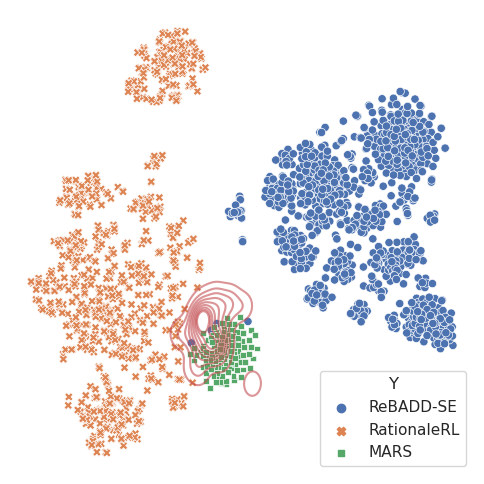

In [25]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.kdeplot(data=data[data['Y']=='ZINC15'], x='X1', y='X2', c='r', alpha=0.6, ax=ax)
sns.scatterplot(data=data[data['Y']!='ZINC15'], x='X1', y='X2', hue='Y', style='Y', ax=ax)

ax.axis('off')

plt.tight_layout()
plt.show()